In [1]:
%matplotlib inline


In [2]:
! pwd

/data/srlab1/TCAT/Analysis/PerDataset/COMBAT


In [3]:
import scanpy  as sc
import muon as mu
import numpy as np
import matplotlib.pyplot as plt
from cnmf import Preprocess
import pandas as pd
import scipy.sparse as sp


sc.logging.print_versions()

/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                 9.1.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
cached_property     1.5.2
cffi                1.15.0
cloudpickle         2.2.1
cnmf                NA
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
dask                2022.02.0
dateutil            2.8.2
debugpy             1.6.0
decorator           5.1.1
defusedxml          0.7.1
entrypoints         0.4
fastcluster         1.2.6
fsspec              2023.1.0
h5py                3.6.0
harmonypy           NA
igraph              0.9.9
ipykernel           6.13.0
ipython_genutils    0.2.0
jedi                0.18.1
jinja2              3.1.1
joblib              1.1.0
jupyter_server      1.16.0
kiwisolver          1.4.2
leidenalg           0.8.9
llvmlite            0.38.0
markupsafe          2.1.1
matplotlib          3.5.1
matplotlib_inline   NA
mpl_toolkits        NA
mudata              0.2.1
muon                0.1.3


# Parameters

In [4]:
! ls ../../../Data/PerDataset/COMBAT

ActivationScore.COMBAT.Early-OX40-ICOS-CTLA4-TIMD4_Mean_Thresh0_2.tsv
ADT_TP10KCLR_ForMAGIC.h5ad
AUC_GatePrediction_StepwiseLogistic_20230704.tsv
AUC_GatePrediction_StepwiseLogistic.tsv
COMBAT.20230927
COMBAT.20230927.Iter200
COMBAT.20230927.Iter200.Spectra_Scores.Relabeled.tsv
COMBAT.20230927.Iter200.Spectra_TPM.Relabeled.tsv
COMBAT.20230927.Iter200.Usage.Relabeled.tsv
Combat_ADT_info_final.tsv
COMBAT.AllPBMCs.TCAT.Usage.20230910.tsv
Combat_Antibody_Info.xlsx
COMBAT-CITESeq-DATA.h5ad
COMBAT-CITESeq-DATA.Raw.ADTfixed.B.20231230.ADT.TP10K.VarNorm.leidenRNA_MI.tsv
COMBAT-CITESeq-DATA.Raw.ADTfixed.B.20231230.ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad
COMBAT-CITESeq-DATA.Raw.ADTfixed.B.20231230.FiltForcNMF.h5ad
COMBAT-CITESeq-DATA.Raw.ADTfixed.B.20231230.metadata.tsv
COMBAT-CITESeq-DATA.Raw.ADTfixed.B.20231230.RNA_and_ADT.TP10K.h5ad
COMBAT-CITESeq-DATA.Raw.ADTfixed.B.20231230.RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv
COMBAT-CITESeq-DATA.Raw.ADTfixed.B.20231230.RNA_and_ADT.

In [5]:
params = {
'harmony_vars' : ['Institute',  'COMBAT_participant_timepoint_ID'],
'filter_mito_thresh' : None,
'RNA_normalize_targetsum' : 1e4,
'n_top_rna_genes' : 2000,
'n_top_adt_genes' : 75,
'feature_type_col' : 'feature_types', # Set to None if only RNA is included
'adt_feature_name' : 'Antibody Capture', # all other genes assumed to be RNA
'min_cells_per_RNA_gene' : 10,
'min_rna_counts_per_cell' : 500,
'filter_mito_genes' : False,
'filter_dot_genes' : True,
'max_scaled_thresh' : None,
'quantile_thresh' : .9999,
'n_neighbors' : 30,
'n_rna_pcs' : 32,
'n_adt_pcs' : 21,
'name_addition' : '.20231231.', # Set to a string if you want to append that to the name of saved files to run multiple versions of script
'random_seed' : 14
}


if params['name_addition'] is None:
    toadd = ''
else:
    toadd = params['name_addition']


original =  '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.h5ad'
paths = {
        'Original' : original, # AnnData containing RNA +/- ADT,
        'RNA_Varnorm_Harmony':original.replace('.h5ad', toadd + 'RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad'),
        'RNA_HVG_List':original.replace('.h5ad', toadd + 'RNA.HVGlist.tsv'),
        'Metadata' : original.replace('.h5ad', toadd + 'metadata.tsv'),
        'Raw_Filt_For_cNMF' : original.replace('.h5ad', toadd + 'FiltForcNMF.h5ad'),
        }
        
if params['feature_type_col'] is None:
    ## Output RNA only TP10K file if no ADT
    paths['TP10K'] = original.replace('.h5ad', toadd + 'RNA.TP10K.h5ad')
else:
    ## Output both RNA and ADT files
    paths['ADT_MI_Rank'] = original.replace('.h5ad', toadd + 'ADT.TP10K.VarNorm.leidenRNA_MI.tsv')
    paths['ADT_Varnom_Harmony'] = original.replace('.h5ad', toadd + 'ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['RNA_and_ADT_TP10K'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.h5ad')
    paths['RNA_and_ADT_HVG_List'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.HVGlist.tsv')
    paths['RNA_and_ADT_Varnorm_Harmony_WNN'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5mu')
    paths['RNA_and_ADT_Varnorm_Harmony'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad')
    paths['WNN_UMAP'] = original.replace('.h5ad', toadd + 'RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv')
    
paths   
                                                                                            

{'Original': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.h5ad',
 'RNA_Varnorm_Harmony': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.20231231.RNA.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_HVG_List': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.20231231.RNA.HVGlist.tsv',
 'Metadata': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.20231231.metadata.tsv',
 'Raw_Filt_For_cNMF': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.20231231.FiltForcNMF.h5ad',
 'ADT_MI_Rank': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.20231231.ADT.TP10K.VarNorm.leidenRNA_MI.tsv',
 'ADT_Varnom_Harmony': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.20231231.ADT.VarNorm.HVG.HarmonyGeneCorrect.h5ad',
 'RNA_and_ADT_TP10K': '../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.20231231.RNA_and_ADT.TP10K.h5ad',
 'RNA_and_ADT_HVG_List': '../../../Dat

# Run pipeline

Only considering the two last: ['.ADTfixed', '.h5ad'].
Only considering the two last: ['.ADTfixed', '.h5ad'].


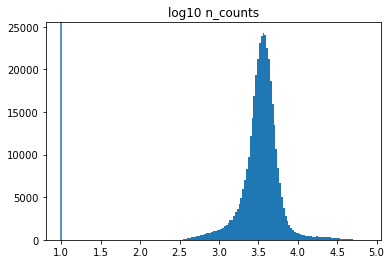

In [6]:
adata = sc.read(paths['Original'])


if params['feature_type_col'] is not None:
    adata_RNA = adata[:, adata.var[params['feature_type_col']]!=params['adt_feature_name']]
    adata_ADT = adata[:, adata.var[params['feature_type_col']]==params['adt_feature_name']]
    
    adata_ADT.var_names_make_unique()
    adata_ADT.var['features_renamed'] = adata_ADT.var.index
    
else:
    adata_RNA = adata
    
adata_RNA.var_names_make_unique()
adata_RNA.var['features_renamed'] = adata_RNA.var.index
p = Preprocess(params['random_seed'])


adata_RNA = p.filter_adata(adata_RNA, filter_mito_thresh=params['filter_mito_thresh'], min_cells_per_gene = params['min_cells_per_RNA_gene'],
             min_counts_per_cell = params['min_rna_counts_per_cell'], filter_mito_genes = params['filter_mito_genes'],
             filter_dot_genes = params['filter_dot_genes'], makeplots=True)
adata_ADT = adata_ADT[adata_RNA.obs.index, :]

/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/PHShome/dk718/miniforge3/envs/cnmf_env2v2/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


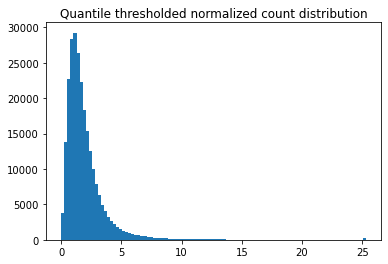

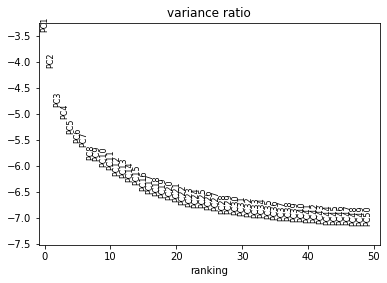

2024-01-07 16:57:36,848 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-01-07 16:59:23,620 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-01-07 16:59:27,968 - harmonypy - INFO - Iteration 1 of 20


In [ ]:
(adata_RNA_c, adata_tp10k, hvgs) = p.preprocess_for_cnmf([adata_RNA, adata_ADT], harmony_vars=params['harmony_vars'],
                                                         n_top_rna_genes = params['n_top_rna_genes'], librarysize_targetsum= 1e4,
                                                         max_scaled_thresh = params['max_scaled_thresh'],
                                                         quantile_thresh = params['quantile_thresh'], makeplots=True,
                                                         max_iter_harmony=40)

In [ ]:
3

In [ ]:
adata_tp10k.X = sp.csr_matrix(adata_tp10k.X)

In [ ]:
sc.write(paths['RNA_Varnorm_Harmony'], adata_RNA_c)
sc.write(paths['RNA_and_ADT_TP10K'], adata_tp10k)

In [ ]:
with open(paths['RNA_HVG_List'], 'w') as F:
    F.write('\n'.join(hvgs))

In [ ]:
adata_RNA_c.obs.to_csv(paths['Metadata'], sep='\t')

In [ ]:
# Filt raw data to cells used for cnmf only 
adata_RNA_c = sc.read(paths['RNA_Varnorm_Harmony'])
adata_filt = adata[adata_RNA_c.obs.index, ]

In [49]:
adata.shape, adata_RNA_c.shape, adata_filt.shape

((400925, 20807), (399599, 2000), (399599, 20807))

In [ ]:
paths['Raw_Filt_For_cNMF']

In [ ]:
sc.write(paths['Raw_Filt_For_cNMF'], adata_filt)

In [ ]:
sc.pp.neighbors(adata_RNA_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_rna_pcs'], use_rep='X_pca_harmony')
sc.tl.umap(adata_RNA_c)
adata_RNA_c.obsm['X_harmony_RNA_UMAP'] = adata_RNA_c.obsm['X_umap']
sc.tl.leiden(adata_RNA_c, resolution=1)

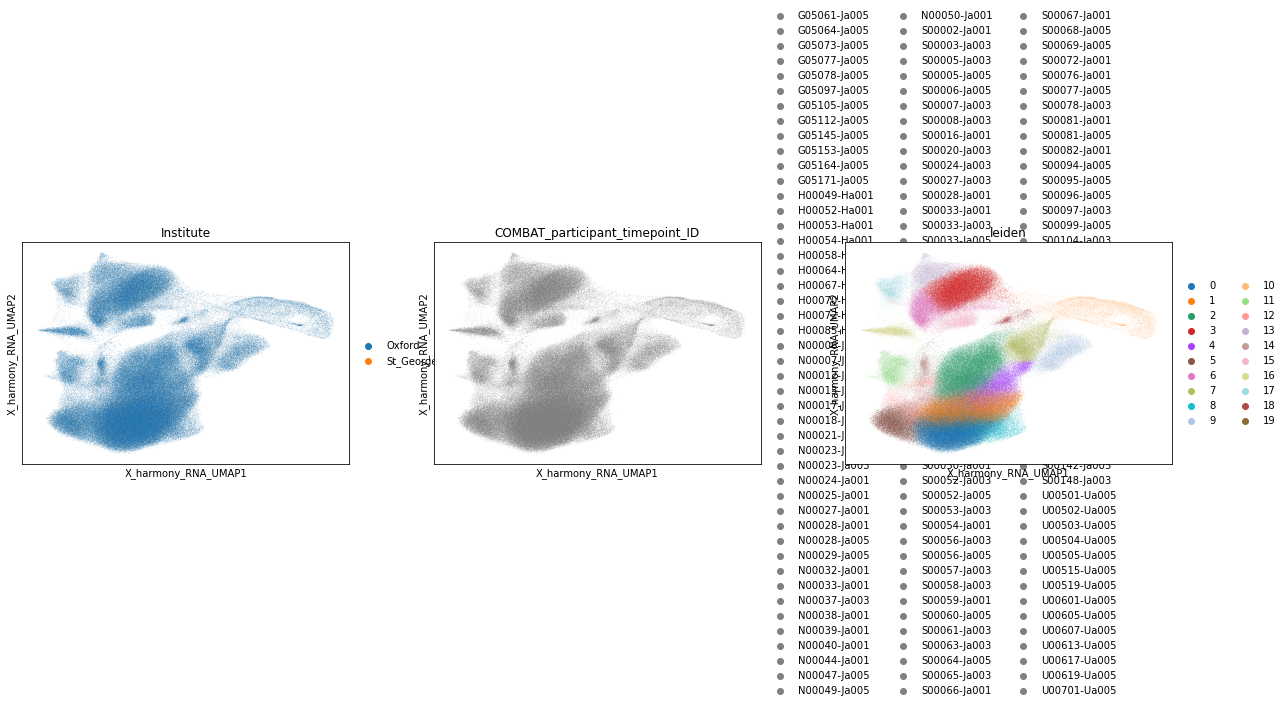

In [50]:
sc.pl.embedding(adata_RNA_c, basis='X_harmony_RNA_UMAP', color= params['harmony_vars'] + ['leiden'])

In [ ]:
adata_ADT = p.select_features_MI(adata_ADT, adata_RNA_c.obs['leiden'], n_top_features = params['n_top_adt_genes'], max_scaled_thresh = params['max_scaled_thresh'], quantile_thresh = params['quantile_thresh'], makeplots=True)

In [ ]:
adata_ADT.var.to_csv(paths['ADT_MI_Rank'], sep='\t')

In [ ]:
adata_ADT_c, adata_ADT_hvgs = p.normalize_batchcorrect(adata_ADT, normalize_librarysize=False, harmony_vars=params['harmony_vars'], n_top_genes = None, max_scaled_thresh = params['max_scaled_thresh'],
                               quantile_thresh = params['quantile_thresh'], makeplots=True)

In [ ]:
sc.pp.neighbors(adata_ADT_c, n_neighbors=params['n_neighbors'], n_pcs=params['n_adt_pcs'], use_rep='X_pca_harmony')

In [46]:
adata_ADT_c

AnnData object with n_obs × n_vars = 399599 × 75
    obs: 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'COMBAT_ID', 'scRNASeq_sample_ID', 'COMBAT_participant_time

In [ ]:
sc.tl.umap(adata_ADT_c)
adata_ADT_c.obsm['X_harmony_ADT_UMAP'] = adata_ADT_c.obsm['X_umap']
sc.tl.leiden(adata_ADT_c, resolution=1)

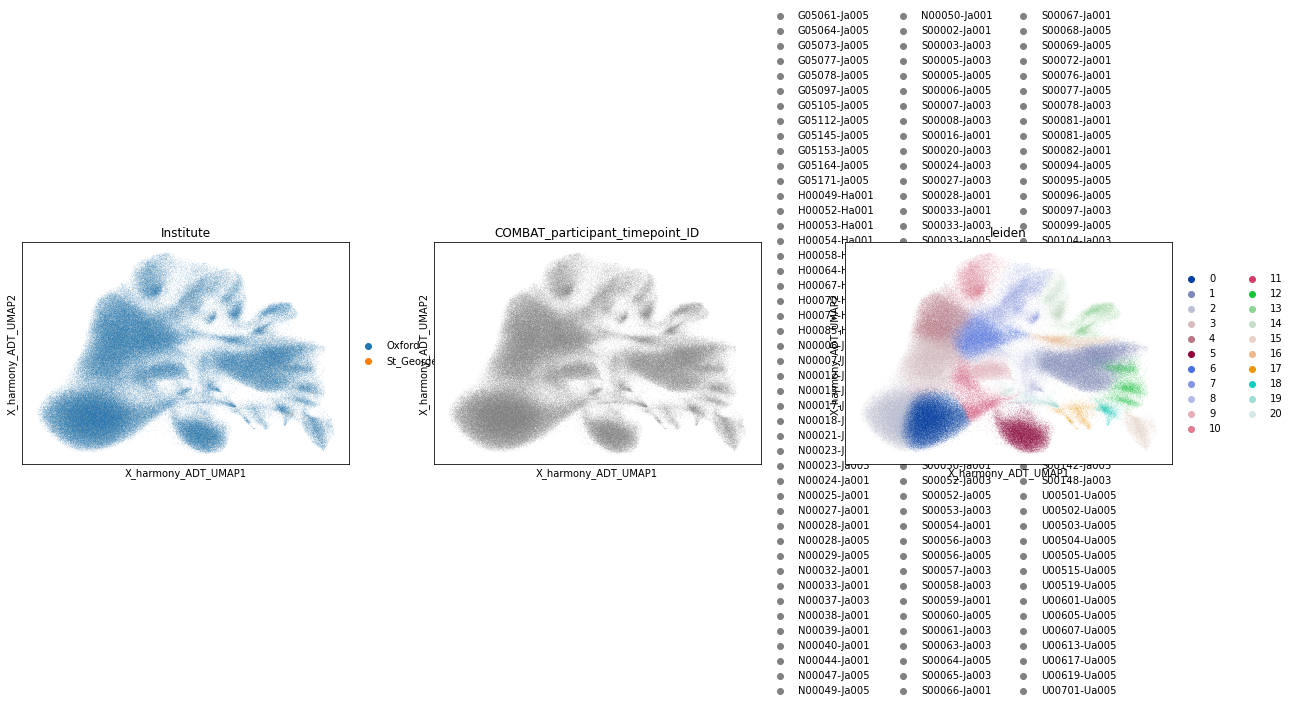

In [47]:
sc.pl.embedding(adata_ADT_c, basis='X_harmony_ADT_UMAP', color= params['harmony_vars'] + ['leiden'])

In [ ]:
sc.write(paths['ADT_Varnom_Harmony'], adata_ADT_c)

In [ ]:
mdata = mu.MuData({'rna': adata_RNA_c, 'prot': adata_ADT_c})
mu.pp.neighbors(mdata, key_added='wnn')
mu.tl.umap(mdata, neighbors_key='wnn', random_state=10)
mdata.obsm["X_wnn_umap"] = mdata.obsm["X_umap"]
mu.pl.umap(mdata, color=['rna:mod_weight', 'prot:mod_weight'], cmap='bwr')
sc.tl.leiden(mdata, resolution=1.0, neighbors_key='wnn', key_added='leiden_wnn')

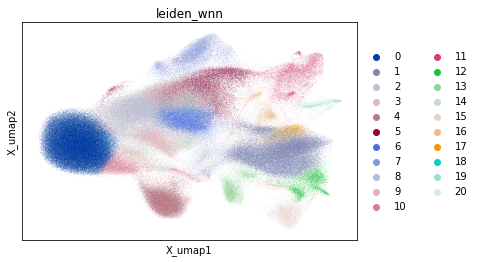

In [48]:
mu.pl.umap(mdata, color=['leiden_wnn'])

In [ ]:
mdata['rna'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']
mdata['prot'].obs['leiden_wnn'] = mdata.obs['leiden_wnn']

In [ ]:
sc.tl.rank_genes_groups(mdata['rna'], groupby='leiden_wnn')

In [ ]:
sc.tl.rank_genes_groups(mdata['prot'], groupby='leiden_wnn')

In [44]:
pd.DataFrame(mdata['rna'].uns['rank_genes_groups']['names']).head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,CCR7,ANKRD55,EEF1A1,CISH,AIF1,LRRN3,SLC40A1,SELL,CLDN5,FAM13A,SOCS3,CXCL13,SCGB3A1,RPS26,EPHB6,NUPR2,RPLP1,GNG8,FOXP2,H1-0
1,CST7,NKG7,CCL5,GZMH,CTSW,PRF1,GZMA,KLRD1,CD8A,PLEK,FGFBP2,HLA-DPB1,GZMB,HOPX,CX3CR1,KLRG1,HLA-DPA1,FCRL6,GNLY,CD8B
2,CCR7,SLC40A1,CXCL13,EEF1A1,PASK,SELL,CISH,LTB,CDO1,FAM13A,CXCR5,SOCS3,GREM2,ANKRD55,AREG,RPLP1,NEFL,PCSK1N,GPR15,RGS16
3,VIM,S100A11,ANXA1,CAPG,PI16,CCR4,ITGB1,TNFSF10,LTB,SLC40A1,NEFL,EEF1A1,CISH,S100A4,CCR10,CCR8,CXCL13,TNFRSF4,FOS,AHNAK
4,CD8B,CCR7,CD8A,AIF1,EEF1A1,RPLP1,PECAM1,S100B,LRRN3,CD248,SELL,MT-ND4L,FCER1G,RPS26,CPA5,PASK,RPLP0,CD79A,CPNE2,CISH
5,CD52,TMSB4X,TMSB10,LIMS1,RAC2,CNN2,ARPC3,MYL6,ARHGDIB,S100A11,SH3BGRL3,UCP2,IL32,CORO1B,ITM2A,PFN1,MT-CO1,ACTG1,TRIB2,CORO1A
6,LTB,CCR6,KLRB1,AQP3,S100A4,EEF1A1,CTSH,CMTM6,CISH,VIM,S100A11,RPLP0,PDE4D,FOS,RPLP1,ITGB1,TNFRSF4,ANXA1,RORC,NFKBIA
7,FOXP3,IL2RA,RTKN2,IL32,GBP5,NCF4,CCR4,CTLA4,TIGIT,IKZF2,LGALS3,FAS,SHMT2,HSPA1A,S100A4,HPGD,ENTPD1,HLA-DRB1,HLA-DQB1,F5
8,CD8B,CD8A,FOS,CAPG,ANXA1,ITGB1,EEF1A1,CCR8,CISH,KRT1,VIM,ID2,ZP1,NEFL,PTGDR2,PPP1R15A,LYAR,AHNAK,ZFP36,TNFAIP3
9,KLRB1,ITGA4,EEF1A1,RPLP1,CXCL13,LTB,LIMS1,AQP3,RPLP0,FOS,CCR6,CISH,CORO1B,CMTM6,CDO1,CCR9,PASK,TNFSF13B,CXCR5,PPP1R15A


In [45]:
pd.DataFrame(mdata['prot'].uns['rank_genes_groups']['names']).head(10).T

,0,1,2,3,4,5,6,7,8,9
0,AB_CD4-2,AB_CD3-1,AB_abTCR,AB_CD7,AB_CCR7,AB_CD27-1,AB_CD47,AB_CD62L,AB_CD45RA,AB_CD360
1,AB_KLRG1_MAFA,AB_CD8,AB_CD244,AB_CD11a,AB_CD314,AB_CD319,AB_CD57,AB_CD18,AB_CX3CR1,AB_CD49d
2,AB_mouseCD49f,AB_CD4-2,AB_CD47,AB_CD28,AB_CD52,AB_CD29,AB_CD5,AB_CD127,AB_CD27-1,AB_CD82
3,AB_CD82,AB_CD194,AB_mouseCD49f,AB_CD45RO,AB_CD99,AB_CD95,AB_CD28,AB_CD4-2,AB_CD5,AB_CD224
4,AB_CD45RA,AB_CD8,AB_CD31,AB_CD73,AB_CD27-1,AB_CD314,AB_CD7,AB_CD360,AB_CD305,AB_CCR7
5,AB_CD45RO,AB_CD4-2,AB_CD95,AB_CD28,AB_CD279,AB_CD278,AB_CD5,AB_CD99,AB_CD82,AB_CD150
6,AB_mouseCD49f,AB_CD4-2,AB_CD2,AB_CD127,AB_CD28,AB_CD226-2,AB_CD26,AB_CD29,AB_CD95,AB_CD45RO
7,AB_CD95,AB_CD194,AB_CD39,AB_CD25,AB_CD45RO,AB_CD28,AB_CD4-2,AB_CD58,AB_TIGIT,AB_CD278
8,AB_CD8,AB_CD99,AB_CD2,AB_CD314,AB_CD226-2,AB_CD127,AB_CD96,AB_mouseCD49f,AB_CD44-1,AB_CD82
9,AB_CD4-2,AB_Integrin-7,AB_CD28,AB_CD49d,AB_CD52,AB_CD161,AB_CD224,AB_CD95,AB_CD127,AB_CD5


In [ ]:
mu.write(paths['RNA_and_ADT_Varnorm_Harmony_WNN'], mdata)

In [51]:
paths['WNN_UMAP']

'../../../Data/PerDataset/COMBAT/COMBAT-CITESeq-DATA.Raw.T.ADTfixed.20231231.RNA_and_ADT.TP10K.VarNorm.HVG.HarmonyGeneCorrect.WNN.UMAP.tsv'

In [ ]:
umap = pd.DataFrame(mdata.obsm['X_wnn_umap'], index=mdata.obs.index, columns=['WNN_UMAP_1', 'WNN_UMAP_2'])

In [ ]:
umap.to_csv(paths['WNN_UMAP'], sep='\t')

In [ ]:
merge_var = pd.concat([adata_RNA_c.var, adata_ADT_c.var], axis=0)            
adata_c = sc.AnnData(np.concatenate((adata_RNA_c.X, adata_ADT_c.X), axis=1), obs=adata_RNA_c.obs, var=merge_var)

In [ ]:
adata_c.obsm['X_pca_rna'] = adata_RNA_c.obsm['X_pca']
adata_c.obsm['X_pca_rna_harmony'] = adata_RNA_c.obsm['X_pca_harmony']
adata_c.obsm['X_umap_rna'] = adata_RNA_c.obsm['X_harmony_RNA_UMAP']

adata_c.obsm['X_pca_adt'] = adata_ADT_c.obsm['X_pca']
adata_c.obsm['X_pca_adt_harmony'] = adata_ADT_c.obsm['X_pca_harmony']
adata_c.obsm['X_umap_adt'] = adata_ADT_c.obsm['X_harmony_ADT_UMAP']
adata_c.obsm['X_umap_WNN'] = mdata.obsm['X_wnn_umap']

In [ ]:
sc.write(paths['RNA_and_ADT_Varnorm_Harmony'], adata_c)